# Creating Data

In [1]:
import requests
import json
import csv

#API_KEY = 0CUKFG69H3TWK38Y
#STOCK SYMBOL = NVDA
# replace the "demo" apikey below with your own key from https://www.alphavantage.co/support/#api-key
url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=NVDA&outputsize=full&apikey=0CUKFG69H3TWK38Y'   # replace API KEY and stock symbol
r = requests.get(url)
data = r.json()

In [2]:
# Extract "Time Series (Daily)" part
time_series = data.get("Time Series (Daily)", {})

# Prepare data for CSV
csv_data = [("Date", "Close")]  # Header for CSV file

# Loop through each date and get the "close" price
for date, daily_data in time_series.items():
    close_price = daily_data.get("4. close", None)
    if close_price:
        csv_data.append((date, close_price))

# Write data to CSV file
csv_file = 'Stock_prices.csv'
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(csv_data)

print(f"Data saved to {csv_file}")

Data saved to Stock_prices.csv


# Preprocessing

In [3]:
import pandas as pd
import numpy as np
from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter

# Ανάγνωση των δεδομένων 
Data = pd.read_csv('Stock_prices.csv')
print(Data.head())

# Έλεγχος δεδομένων
Data.info()

         Date    Close
0  2024-11-01  135.400
1  2024-10-31  132.760
2  2024-10-30  139.335
3  2024-10-29  141.250
4  2024-10-28  140.520
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6292 entries, 0 to 6291
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    6292 non-null   object 
 1   Close   6292 non-null   float64
dtypes: float64(1), object(1)
memory usage: 98.4+ KB


In [4]:
# Μετατροπή των στοιχείων του column Date σε datetime
Data['Date']=pd.to_datetime(Data['Date'])
# Έλεγχος για το αν υπάρχουν ελλιπή δεδομένα 
Data.isna().values.any()

np.False_

In [5]:
# Εφαρμογή Gaussian Φίλτρου

# Καθορισμός σ (τυπική απόκλιση) για το Gaussian φίλτρο
sigma = 2
# Εφαρμογή Gaussian φίλτρου στην στήλη Close
Data['Close'] = gaussian_filter1d(Data['Close'].values, sigma=sigma)

In [6]:
Data.head()

,Date,Close
0,2024-11-01,136.149988
1,2024-10-31,136.829342
2,2024-10-30,137.939574
3,2024-10-29,139.101046
4,2024-10-28,140.009284


In [7]:
# Εφαρμογή Savitzky-Golay Φίλτρου

# Παράδειγμα παραμέτρων
window_length = 5  # Το μήκος του παραθύρου
polyorder = 2      # Τάξη του πολυωνύμου

# Εφαρμογή του φίλτρου Savitzky-Golay στην στήλη Close
Data['Close'] = savgol_filter(Data['Close'].values, window_length=window_length, polyorder=polyorder)

In [8]:
Data.head()

,Date,Close
0,2024-11-01,136.080503
1,2024-10-31,136.970459
2,2024-10-30,137.933131
3,2024-10-29,139.081954
4,2024-10-28,139.995013


# Data exploration

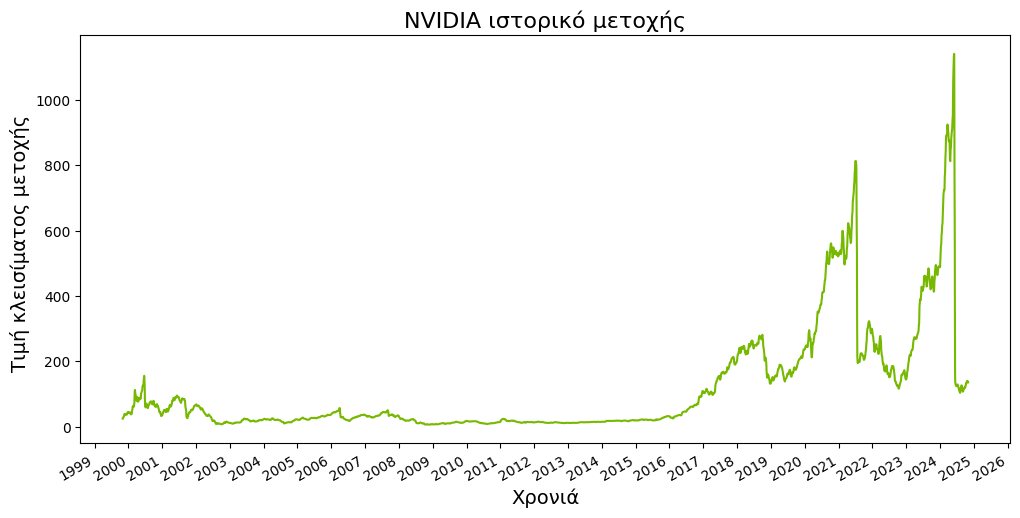

In [9]:
#εισαγωγή βιβλιοθήκης για της ημερομηνίες
import matplotlib.pyplot as plt
import matplotlib.dates as nyears

# Εξαγωγή ημερομηνιών 
years = nyears.YearLocator()

# Εισαγωγή φόρμας ημερομηνιών 
yearsFmt = nyears.DateFormatter('%Y')

fig, ax = plt.subplots(figsize=(12, 6)) 
ax.plot(Data['Date'], Data['Close'], color='#76B900')
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)

# Δημιουργεία γραφήματος
plt.title('NVIDIA ιστορικό μετοχής', fontsize=16)
plt.xlabel('Χρονιά', fontsize=14)
plt.ylabel('Τιμή κλεισίματος μετοχής ', fontsize=14)

# Πειστοφή και ευθυγράμηση των ετικετών 
fig.autofmt_xdate()

# Εμφάνηση γραφικής 
plt.show()

# Lagged Data

In [10]:
New_data = Data.copy()
New_data_col = []

# Δημιουργία καθυστερημένων στηλών
lagged_col_data = {}  # Λεξικό για αποθήκευση δεδομένων καθυστερημένων στηλών
for i in range(1, 7):
    for col in ['Close']:
        lagged_col_name = f"{col}_{i}"  # Δημιουργία ονόματος καθυστερημένης στήλης
        lagged_col_data[lagged_col_name] = New_data[col].shift(-i)  # Δημιουργία καθυστερημένων στηλών
        New_data_col.append(lagged_col_name)

# Συγχώνευση δεδομένων καθυστερημένων στηλών
New_data = pd.concat([New_data, pd.DataFrame(lagged_col_data)], axis=1)

# Συμπλήρωση τιμών NaN με 0
New_data.fillna(0, inplace=True)

#Μετατροπή του index
New_data.set_index('Date',inplace=True)

# Αφαίρεση της στήλης 'Close' από το DataFrame
New_data_column = New_data.pop('Close')

# Εισαγωγή της στήλης 'Close' στο τέλος του νέου Data Frame 
New_data['Close'] = New_data_column

# Εμφάνιση του πρώτου κομματιού του καθυστερημένου DataFrame για έλεγχο των αλλαγών
print(New_data.head(3))
print(New_data.tail(3))

               Close_1     Close_2     Close_3     Close_4     Close_5  \
Date                                                                     
2024-11-01  136.970459  137.933131  139.081954  139.995013  140.585828   
2024-10-31  137.933131  139.081954  139.995013  140.585828  140.919614   
2024-10-30  139.081954  139.995013  140.585828  140.919614  141.029520   

               Close_6       Close  
Date                                
2024-11-01  140.919614  136.080503  
2024-10-31  141.029520  136.970459  
2024-10-30  140.808619  137.933131  
              Close_1    Close_2  Close_3  Close_4  Close_5  Close_6  \
Date                                                                   
1999-11-03  26.065782  25.398109      0.0      0.0      0.0      0.0   
1999-11-02  25.398109   0.000000      0.0      0.0      0.0      0.0   
1999-11-01   0.000000   0.000000      0.0      0.0      0.0      0.0   

                Close  
Date                   
1999-11-03  26.767430  
1999-11-02 

# Train & Validation Data 

In [11]:
from sklearn.model_selection import train_test_split
# Δεδομένα εκπαίδευσης
Train_data = New_data[New_data.index.year <= 2023]
print(Train_data.head(3))
# Δεδομένα επικύρωσης 
Valid_data = New_data[New_data.index.year > 2023]
print(Valid_data.head(3))

               Close_1     Close_2     Close_3     Close_4     Close_5  \
Date                                                                     
2023-12-29  490.667163  491.441291  491.244116  490.624552  490.261232   
2023-12-28  491.441291  491.244116  490.624552  490.261232  490.384625   
2023-12-27  491.244116  490.624552  490.261232  490.384625  490.534423   

               Close_6       Close  
Date                                
2023-12-29  490.384625  489.106251  
2023-12-28  490.534423  490.667163  
2023-12-27  489.869318  491.441291  
               Close_1     Close_2     Close_3     Close_4     Close_5  \
Date                                                                     
2024-11-01  136.970459  137.933131  139.081954  139.995013  140.585828   
2024-10-31  137.933131  139.081954  139.995013  140.585828  140.919614   
2024-10-30  139.081954  139.995013  140.585828  140.919614  141.029520   

               Close_6       Close  
Date                                

In [12]:
X_train = Train_data.drop(['Close'], axis=1) # Εξαίρεση της τελευταίας στήλης, που είναι η ετικέτα κλεισίματος της μςτοχής 
y_train = Train_data['Close']

In [13]:
X_valid = Valid_data.drop(['Close'], axis=1)  # Εξαίρεση της τελευταίας στήλης, που είναι η ετικέτα κλεισίματος της μςτοχής 
y_valid = Valid_data['Close']

# Linear Model

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Δημιουργία και εκπαίδευση του γραμμικού μοντέλου
nvidia_model = LinearRegression()
nvidia_model.fit(X_train, y_train)

coefficients = nvidia_model.coef_
intercept = nvidia_model.intercept_
print("Συντελεστές:", coefficients)
print("Βασική τιμή:", intercept)

Συντελεστές: [ 2.51649594 -1.84907151 -0.11397319  0.50399923  0.07316997 -0.13080291]
Βασική τιμή: 0.024146257719806385


# Validation

In [15]:
# Πρόβλεψη επάνω στα δεδομένα επικύρωσης
y_val_pred = nvidia_model.predict(X_valid)

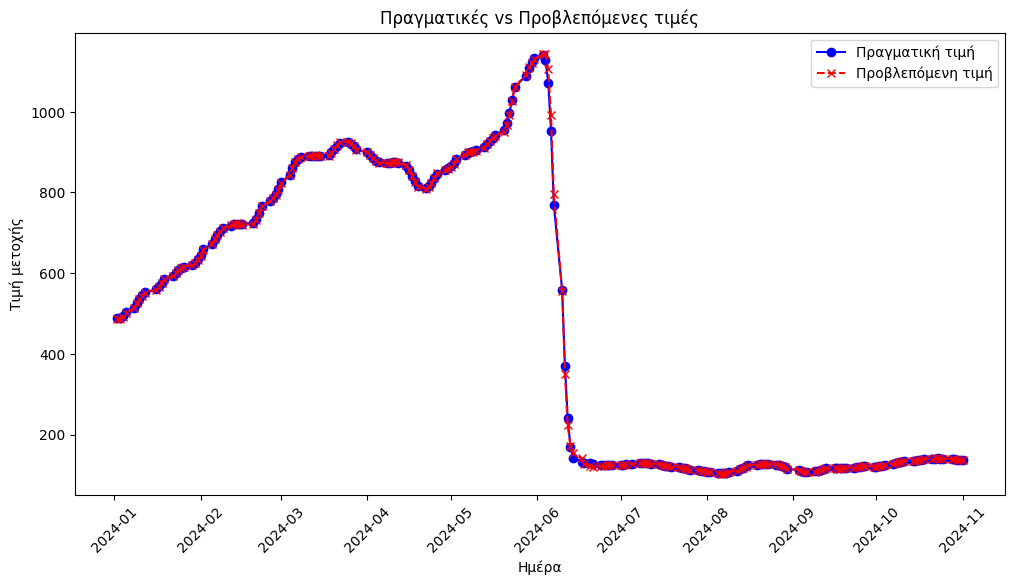

In [16]:
# Δημιουργεία γραφικής πραγματικών vs προβλεπόμενων τιμών
plt.figure(figsize=(12, 6))
plt.plot(y_valid.index, y_valid, label='Πραγματική τιμή', color='blue', marker='o')
plt.plot(y_valid.index, y_val_pred, label='Προβλεπόμενη τιμή', color='red', linestyle='--', marker='x')

# Δημιουργεία της γραφικής 
plt.title('Πραγματικές vs Προβλεπόμενες τιμές')
plt.xlabel('Ημέρα')
plt.ylabel('Τιμή μετοχής')
plt.legend()
plt.xticks(rotation=45)

# Display the plot
plt.show()

In [17]:
# Υπολογισμός μετρικών αξιολόγησης
mse_val = mean_squared_error(y_valid, y_val_pred)
mae_val = mean_absolute_error(y_valid, y_val_pred)
r2_val = r2_score(y_valid, y_val_pred)

# Εκτύπωση αποτελεσμάτων
print(f'Validation MSE: {mse_val}')
print(f'Validation MAE: {mae_val}')
print(f'Validation R²: {r2_val}')

Validation MSE: 23.93157719695708
Validation MAE: 1.6855424501905119
Validation R²: 0.9998154376502353


# Prediction

In [18]:
def data_pred(model):
    x = range(1, 7)
    data = {}
    for n in x:
        data["Close_" + str(n)] = float(input(f"Enter the Close_{n} Price: "))
    
    # Create a DataFrame with one row, providing an index
    Data_to_predict = pd.DataFrame(data, index=[0])  # Create with index=[0] to indicate a single row

    # Ensure the data is in the correct shape (if needed, reshape or use np.array)
    X_new = Data_to_predict.values
    
    # Make the prediction
    predicted_close = model.predict(X_new)
    
    # Display the predicted close
    print("Πρόβλεψη τιμής κλεισίματος:", predicted_close[0])


In [ ]:
import warnings

# Απόκρυψη των warnings
warnings.filterwarnings("ignore")

# Κλήση της συνάρτης πρόβλεψης
data_pred(nvidia_model)

Enter the Close_1 Price:  147.89796
Enter the Close_2 Price:  147.32343
Enter the Close_3 Price:  148.43532
Enter the Close_4 Price:  146.67848
